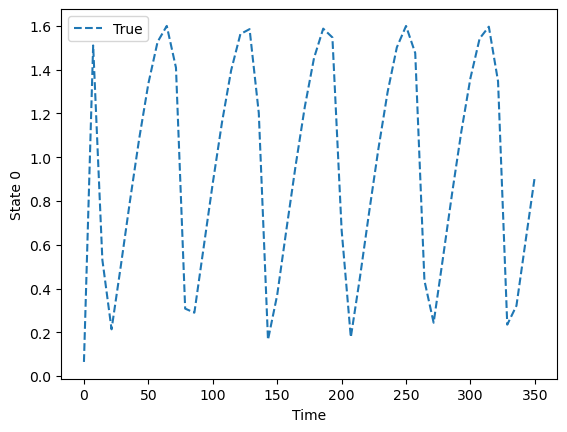

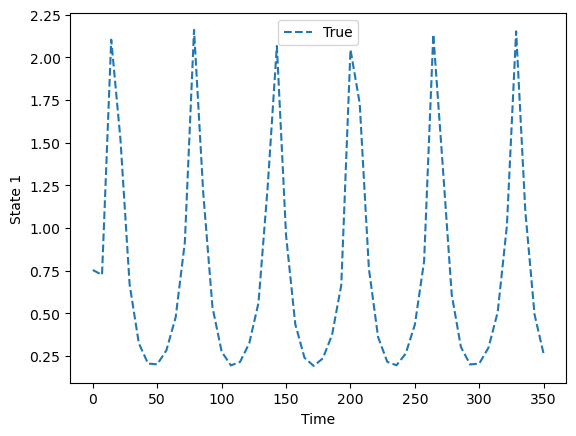

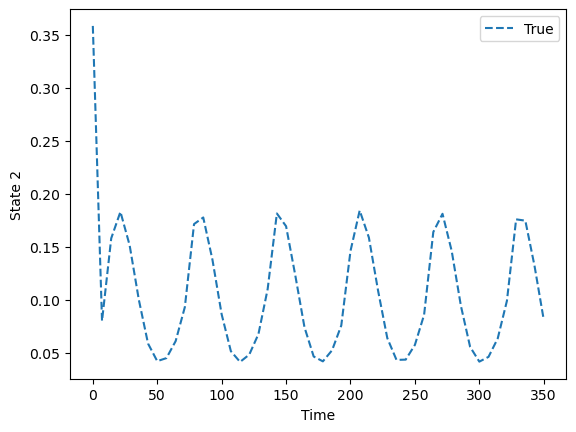

In [2]:
import numpy as np
import matplotlib.pyplot as plt

ntraj = 2148  # number of trajectories
nt = 50  # number of time steps
ny = 7  # number of states

tvec = np.linspace(0, 350, nt)
Y = np.loadtxt("kdata.txt").reshape(ntraj, nt, ny)
Ytrain = Y[:2048, :, :]  # 2048 training trajectories
Ytest = Y[2048:, :, :]  # 100 testing trajectoreis


def plot_traj(ytrue, ymodel=None, tvect=tvec):
    plt.figure()
    plt.plot(tvect, ytrue[:, 0], "--", label="True")
    if ymodel is not None:
        plt.plot(tvect, ymodel[:, 0], "-", label="Model")
    plt.xlabel("Time")
    plt.ylabel("State 0")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(tvect, ytrue[:, 1], "--", label="True")
    if ymodel is not None:
        plt.plot(tvect, ymodel[:, 1], "-", label="Model")
    plt.xlabel("Time")
    plt.ylabel("State 1")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(tvect, ytrue[:, 2], "--", label="True")
    if ymodel is not None:
        plt.plot(tvect, ymodel[:, 2], "-", label="Model")
    plt.xlabel("Time")
    plt.ylabel("State 2")
    plt.legend()
    plt.show()


plot_traj(Ytest[0, :, :])

In [ ]:
import torch
import torch.nn as nn


class KoopmanNN(nn.Module):
    def __init__(
        self,
        input_dim,
        num_autoencoder_layers,
        width_autoencoder_layers,
        latent_dim,
        activation=nn.LeakyReLU,
    ):
        super(KoopmanNN, self).__init__()
        encoder = []
        decoder = []
        for i in range(num_autoencoder_layers):
            if i == 0:
                encoder.append(nn.Linear(input_dim, width_autoencoder_layers))
            else:
                encoder.append(
                    nn.Linear(
                        width_autoencoder_layers, width_autoencoder_layers
                    )
                )
            encoder.append(activation())
            encoder.append(nn.Dropout(0.15))
        encoder.pop()
        encoder.append(nn.Linear(width_autoencoder_layers, latent_dim))
        self.encoder = nn.Sequential(*encoder)

        for i in range(num_autoencoder_layers):
            if i == 0:
                decoder.append(nn.Linear(latent_dim, width_autoencoder_layers))
            else:
                decoder.append(
                    nn.Linear(
                        width_autoencoder_layers, width_autoencoder_layers
                    )
                )
            decoder.append(activation())
            decoder.append(nn.Dropout(0.15))
        decoder.pop()
        decoder.append(nn.Linear(width_autoencoder_layers, input_dim))
        self.decoder = nn.Sequential(*decoder)

        self.K_matrix = nn.Linear(latent_dim, latent_dim, bias=False)
        self.K_matrix.weight.data = (
            torch.randn(latent_dim, latent_dim) / latent_dim
        )

    def forward(self, x):
        z = self.encoder(x)
        xrecon = self.decoder(z)
        kz = self.K_matrix(z)
        xhat = self.decoder(kz)
        return xrecon, z, kz, xhat


def loss(x, xrecon, zs, kzs, xpred, alphas=[1, 1, 1]):
    recon_term = torch.mean((x - xrecon) ** 2)
    pred_term = torch.mean((x - xpred) ** 2)
    koopman_term = torch.mean((kzs - zs) ** 2)
    return (
        alpha[0] * recon_term + alpha[1] * pred_term + alpha[2] * koopman_term,
        recon_term,
        pred_term,
        koopman_term,
    )


def generate_traj(Yi, model, nt):
    y0 = Yi[0, :]
    xrecons = []
    zs = []
    kzs = []
    xpreds = [y0]

    xrecon, z0, kz, xpred = model(y0)
    xrecons.append(xrecon)
    zs.append(z0)
    kzs.append(kz)
    xpreds.append(xpred)
    for i in range(1, nt):
        xrecon, _, _, _ = model(Yi[i])
        xrecons.append(xrecon)
        z = model.encoder(xpreds[-1])
        kz = z0
        for _ in range(i + 1):
            kz = model.K_matrix(kz)
        xpred = model.decoder(kz)
        zs.append(z)
        kzs.append(kz)
        xpreds.append(xpred)

    zs.pop(0)
    kzs.pop()
    xpreds.pop()

    xrecons = torch.stack(xrecons)
    zs = torch.stack(zs)
    kzs = torch.stack(kzs)
    xpreds = torch.stack(xpreds)
    return xrecons, zs, kzs, xpreds


C:\Users\romrellb\AppData\Local\Temp\ipykernel_2920\1069428043.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("koopman_model.pt")
100%|██████████| 3

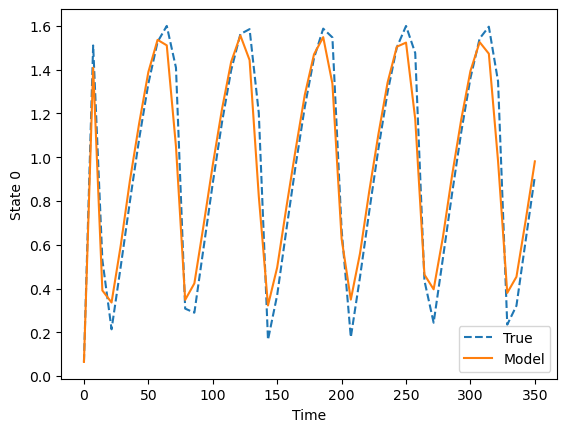

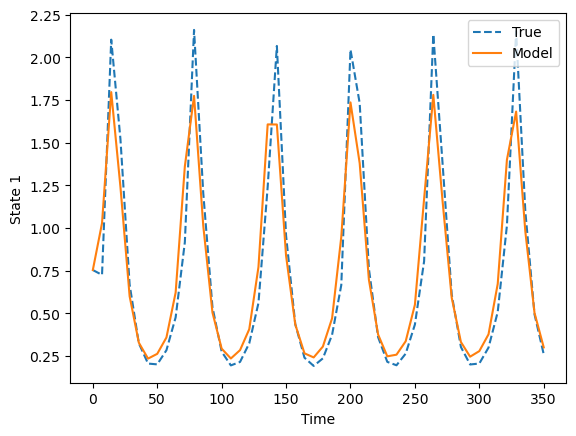

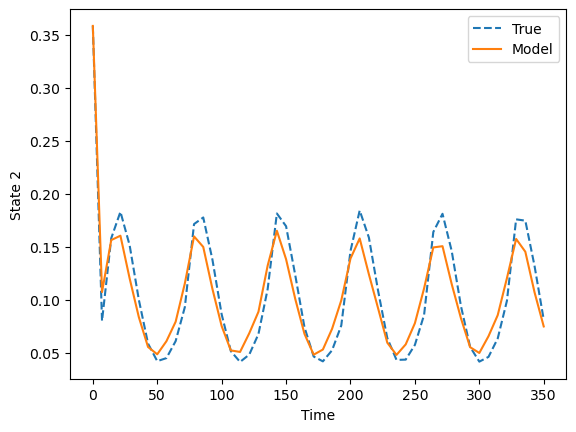

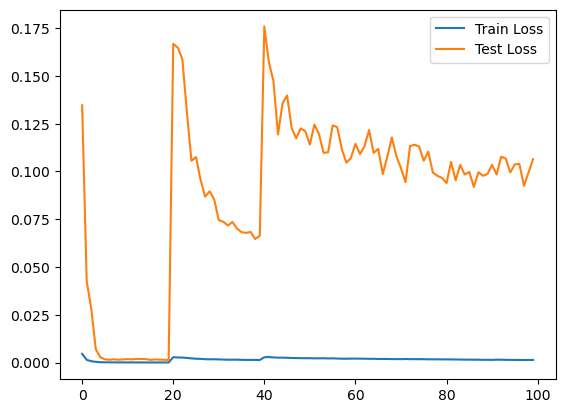

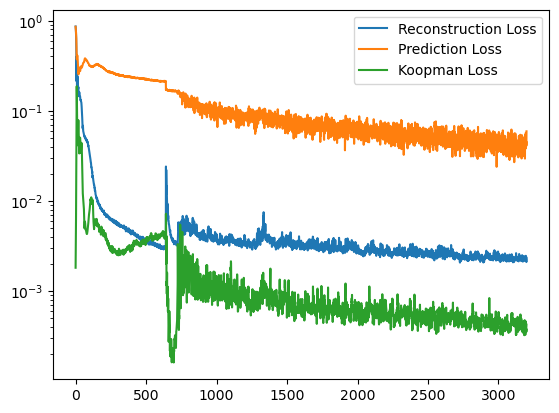

In [4]:
# koopman loss: does each point after one follow linearity
#               ie. $phi(x_{m+1}) = K^m phi(x_1)$ for all m
# and prediction loss: is the state space prediction good
#     ie $x_{m+1} = phi^{-1}(K^m * phi(x_1))$ for all m
from tqdm import tqdm
import os

Epochs = 100
train_size = 2048
batch_size = 64

model = KoopmanNN(ny, 4, 256, latent_dim=32)
if os.path.exists("koopman_model.pt"):
    model = torch.load("koopman_model.pt")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.8,
    patience=train_size,
    cooldown=train_size // 4,
    min_lr=1e-7,
)

tqdm = tqdm(total=Epochs * train_size // batch_size)
Ytrain = torch.tensor(Ytrain, dtype=torch.float32)
# Ytrain is shape Ntraj, Nt, Ny
Ytrain = Ytrain.permute(1, 0, 2)
# Ytrain is shape Nt, Ntraj, Ny
Ytest = torch.tensor(Ytest, dtype=torch.float32)
# Ytest = Ytest.permute(1, 0, 2)
Ytrain = Ytrain.cuda()
Ytest = Ytest.cuda()
model = model.cuda()

train_loss = []
test_losses = []
reconlosses = []
predlosses = []
koopmanlosses = []

alpha = [1, 0, 0]
try:
    for epoch in range(Epochs):
        Ytrain = Ytrain[:, torch.randperm(Ytrain.size()[1])]
        model.train()
        epoch_loss = 0
        if epoch == 20:
            alpha = [1, 1, 1]
        elif epoch == 40:
            alpha = [1, 2, 2]
        for i in range(0, train_size, batch_size):
            optimizer.zero_grad()
            Yi = Ytrain[:, i : i + batch_size, :]
            xrecons, zs, kzs, xpreds = generate_traj(Yi, model, nt)
            traj_loss, recon_term, pred_term, koopman_term = loss(
                Yi, xrecons, zs, kzs, xpreds, alpha
            )
            reconlosses.append(recon_term.item())
            predlosses.append(pred_term.item())
            koopmanlosses.append(koopman_term.item())
            epoch_loss += traj_loss
            traj_loss.backward()
            optimizer.step()
            tqdm.set_postfix(
                {
                    "Reconstruction Loss": recon_term.item(),
                    "Prediction Loss": pred_term.item(),
                    "Koopman Loss": koopman_term.item(),
                    "epoch_loss": epoch_loss.item(),
                    "test_loss": test_losses[-1] if len(test_losses) > 0 else 0,
                }
            )
            tqdm.update(1)
            scheduler.step(traj_loss)
        epoch_loss /= train_size
        train_loss.append(epoch_loss.item())
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for i in range(100):
                Yi = Ytest[i, :, :]
                xrecons, zs, kzs, xpreds = generate_traj(Yi, model, nt)
                traj_loss, _, _, _ = loss(Yi, xrecons, zs, kzs, xpreds)
                test_loss += traj_loss
        test_loss /= 100
        test_losses.append(test_loss.item())
        # print(
        #     f"Epoch {epoch} train loss: {epoch_loss}, test loss: {test_loss}, lr: {optimizer.param_groups[0]['lr']}"
        # )
except KeyboardInterrupt:
    pass
except Exception as e:
    print(e)
    quit()

torch.save(model, "koopman_model.pt")

Ytest = Ytest.cpu()
model = model.cpu()

Y0 = Ytest[0, :, :]
xrecons, zs, kzs, xpreds = generate_traj(Y0, model, nt)
plot_traj(Y0.detach().numpy(), xpreds.detach().numpy())

plt.figure()
plt.plot(train_loss, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(reconlosses, label="Reconstruction Loss")
plt.plot(predlosses, label="Prediction Loss")
plt.plot(koopmanlosses, label="Koopman Loss")
plt.yscale("log")
plt.legend()

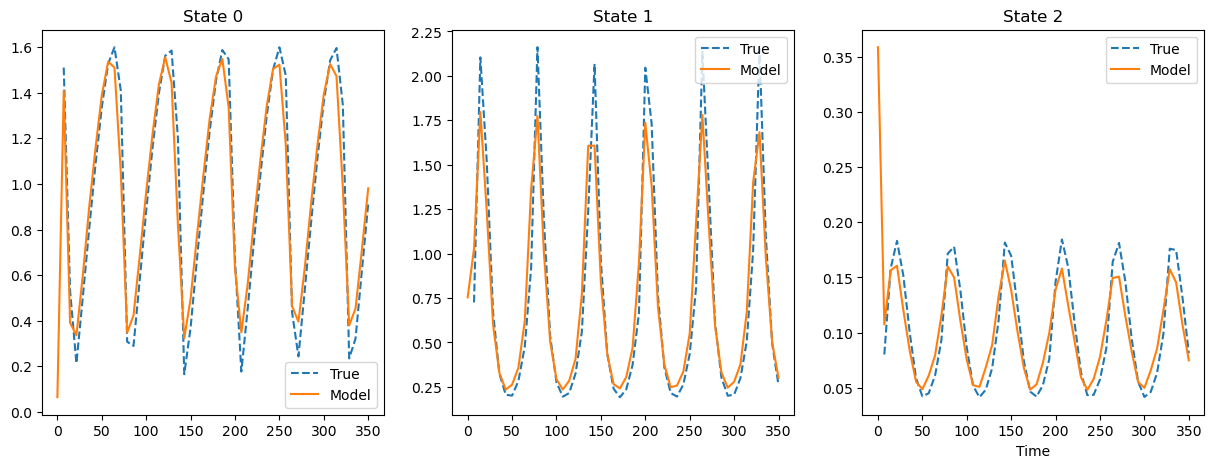

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ytrue = Ytest[0, :, :].detach().numpy()
ymodel = xpreds.detach().numpy()
tvect = tvec

ax[0].plot(tvect[1:], ytrue[1:, 0], "--", label="True")
if ymodel is not None:
    ax[0].plot(tvect, ymodel[:, 0], "-", label="Model")
plt.xlabel("Time")
ax[0].set_title("State 0")
ax[0].legend()

ax[1].plot(tvect[1:], ytrue[1:, 1], "--", label="True")
if ymodel is not None:
    ax[1].plot(tvect, ymodel[:, 1], "-", label="Model")
# ax[1].xlabel("Time")
ax[1].set_title("State 1")
ax[1].legend()

ax[2].plot(tvect[1:], ytrue[1:, 2], "--", label="True")
if ymodel is not None:
    ax[2].plot(tvect, ymodel[:, 2], "-", label="Model")
# ax[2].xlabel("Time")
ax[2].set_title("State 2")
ax[2].legend()
